# Feature Importance and Selection
### Author: Anawat Putwanphen

### Table of Contents
- Why do we need Feature Importance?
- What is Feature Importance? and Types of Feature Importance techniques 
- Concept Relevance and Redundancy
- Model-based strategies feature importance
 - Permutation importance
 - Drop column importance
- Model-free stretegies (Working directly from the data)
- Feature Importance Strategies Comparison 
 - Effect of co-dependence features
- Automatic Feature Selection
- Variance and empirical p-values for feature importances

<br>

## Why do we need Feature Importance?

Frequently, we think of the only focus of machine learning models is to optimize model performance on selected metrics. However, **Understanding how a model works and how features/predictors contribute to its prediction is just as importance.**

Treating our machine learning models as completely black box tools introduce us to some types of risk and issue to the one using it, For example, machine models for automated decision in legal field could implicitly be highly biased toward some ethnicity; Sometimes, these biases are not ethically acceptable or not even legally acceptable. Another example for technical issue is, models trained on biased data, for example, the model for predicting cars price could heavily relies “car_id”. As “car_id” increase the higher the price is because newer cars get higher “car_id” value. Such model would not perform well outside of training data as “car_id” could be reset or even change the format anytimes. Feature Importance techniques can help us detect mentioned issues.

Interpretation of a model is also useful in business settings. Business development manager, Marketing manager, and etc. would eagerly want to gain some insight into why their forecasting models forecast significantly higher number on some time of the day/week/month or some customer groups.  They can use this information to develop strategies to improve the business.


## What is Feature Importance?
Feature importance is a set of techniques aims to **interpret machine learning by assigning some type of score that reflect how much features/predictors contribute to model prediction**. Feature Importance is also used in Feature Selection process to determine the best subset of features which improves model performance, reduces risk of overfitting by reducing model complexity, and could also reduces training time.


## Types of Feature Importance
There are several forms of feature importance. In this document we are going to explore 2 main distinctions.
1. Model-based strategies
 <br>1.1 Model-Specific
 <br>1.2 Model-Agnostic<br>
    &nbsp;&nbsp;&nbsp;&nbsp;1.2.1 Permutation Importance<br>
    &nbsp;&nbsp;&nbsp;&nbsp;1.2.2 Drop Importance
2. Calculate Feature Importance by working directly from the data (model-free)
 <br>2.1 Spearman's rank correlation coefficient 
 <br>2.2 mRMR



In [1]:
%run featimp

## 1. Model-based Strategies
## 1.1 Model-Specific
Model-Specific strategies extract feature importance or interpretation from the underlying structure/assumption of a specific model<br>
such as coefficents in linear regression, gini/MSE drop in Random forest, and etc. This document will specifically discuss about gini/MSE drop feature importance.

### Default Random Forest Feature Importance (gini/MSE drop)
It's one of the most common way to compute Feature Importance. scikit-learn's implementation of RandomForestClassifier and RandomForestRegressor use "mean decrese in impurity" to compute feature importance. In recent years, **Default scikit-learn's Random Forest Feature Importance was critized for its reliability and consistency from machine learning practitioners.** Carolin Strobl et al indicate in the conclusion of *Bias in random forest variable importance measures: Illustrations, sources and a solution* that "the original random forest method the variable importance measures are affected by the number of categories and scale of measurement of the predictor variables, which are no direct indicators of the true importance of the variable." 
<br><br>We are going to demonstrate some of the inconsistency behavior from Default Random Forest Feature Importance in the next example.

#### Example #1 Default Feature Importance using sklearn's Random Forest

In this example, we are going to use the classic boston house-prices dataset from sklearn.dataset to fit and predict house prices in boston.<br>

13 different features in boston dataset (https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html):
<br>CRIM - per capita crime rate by town
<br>ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
<br>INDUS - proportion of non-retail business acres per town.
<br>CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
<br>NOX - nitric oxides concentration (parts per 10 million)
<br>RM - average number of rooms per dwelling
<br>AGE - proportion of owner-occupied units built prior to 1940
<br>DIS - weighted distances to five Boston employment centres
<br>RAD - index of accessibility to radial highways
<br>TAX - full-value property-tax rate per 10,000
<br>PTRATIO - pupil-teacher ratio by town
<br>B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
<br>LSTAT - % lower status of the population

First, we will training a default Random Forest to keep it simple and focus on feature importance. Then, we will add a new feature construct from completely random number to observe the behaviour of feature importance in Default Feature Importance.

In [2]:
# Load and fit data
rgr_data = load_boston()
X, y = rgr_data['data'], rgr_data['target']
rgr = RandomForestRegressor()
rgr.fit(X, y)

RandomForestRegressor()

#### 1. Compute Original Feature Importance

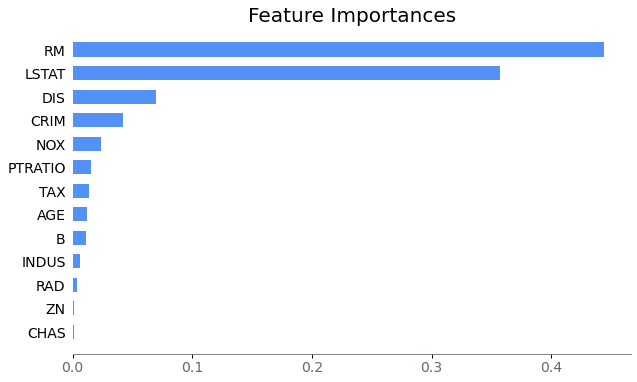

In [3]:
plot_feature_importances(rgr.feature_importances_, rgr_data['feature_names'])

#### 2. Now, we introduce one completely random into dataset. Let's see its performance

In [4]:
X, y = rgr_data['data'], rgr_data['target']
new_col = np.random.rand(X.shape[0], 1)
X_new = np.append(X, new_col, axis=1)
rgr = RandomForestRegressor()
rgr.fit(X_new, y)

RandomForestRegressor()

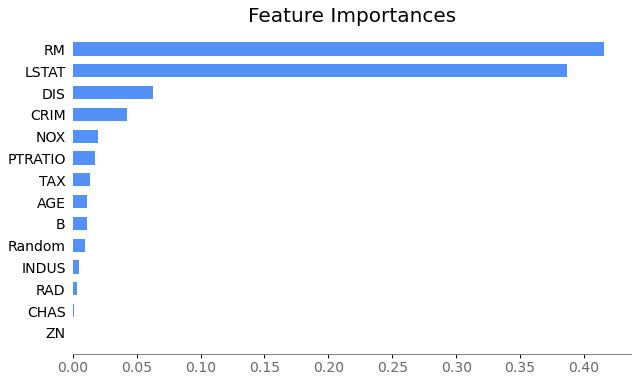

In [5]:
plot_feature_importances(rgr.feature_importances_, np.append(rgr_data['feature_names'], ['Random'], axis=0))

<br>

**Observation**:
Notice that **a completely random number feature "Random" is more importance than 4 features: INDUS, RAD, ZN, and CHAS** 
and its importance score is not 0

## 1.2 Model-Agnostic
Model-Agnostic approach does not rely on the machine learning models' interpretability. It seperates the explanation task from the model using a different set of techniques. Any models can use this method compute feature importance. The provided flexibility of Model-Agnostic enable us to build the high performance model and understand how the model make decision without worrying if the model has interpretability function or not.

In this document we are going to explore 2 techniques 1. permutation importance 2. drop column importance


### 1.1.1 Permutation Importance
The concept is really simple and straight forward. The importance of a feature $x_j$ is measure by the drop in the model's performance after <br>
permuting it (breaks relationship between $x_j$ and response variable) or the increase in the model's error. The more the model's performance drops, the more "important" a feature is.

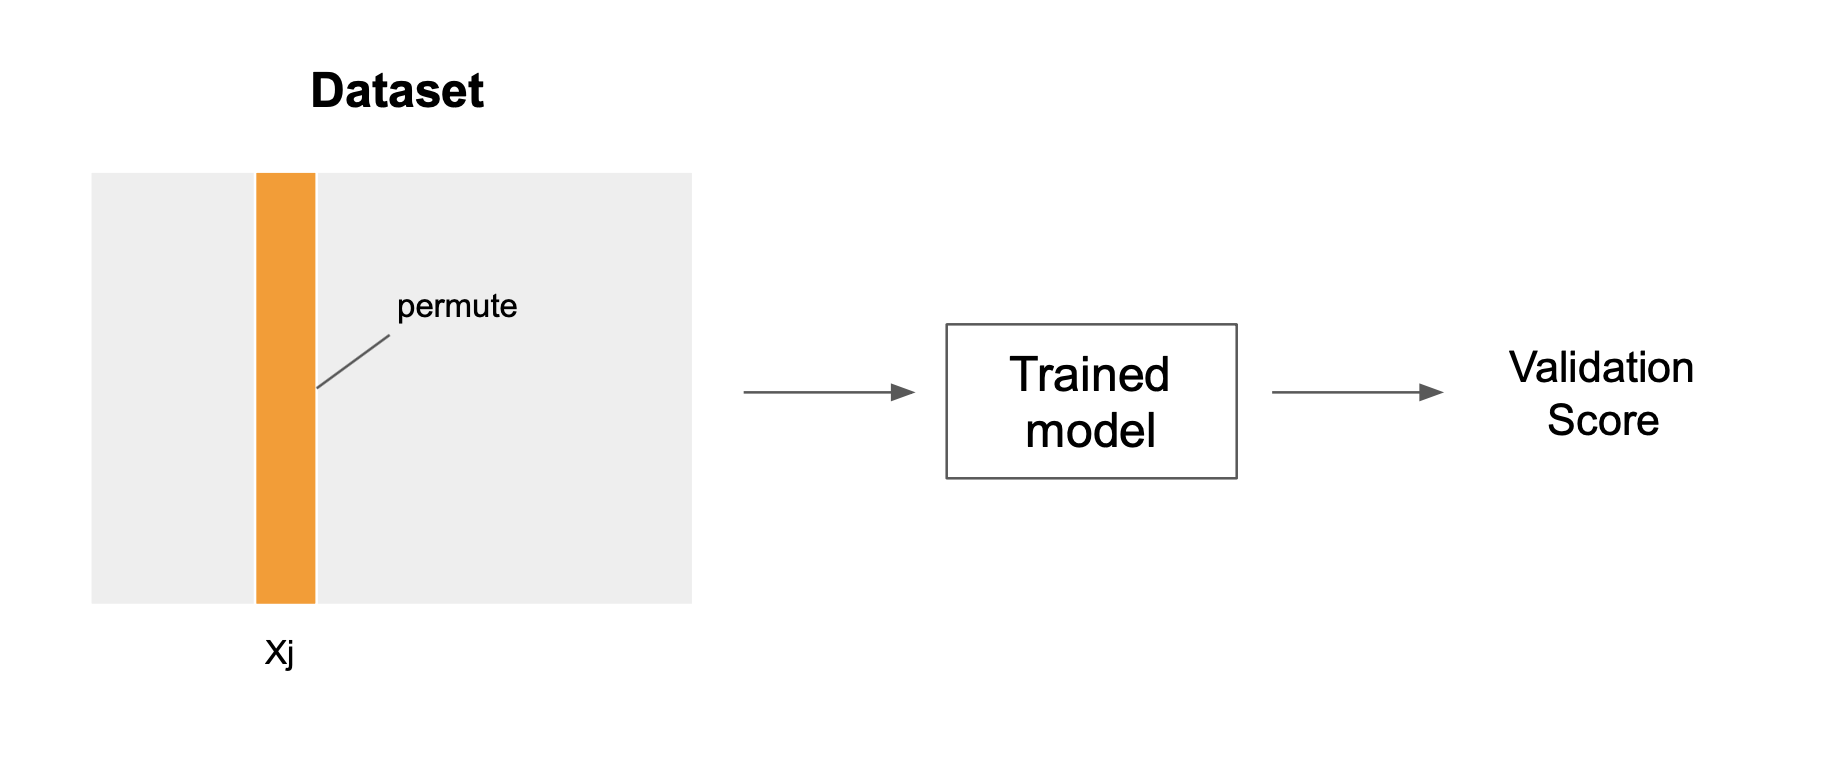

In [53]:
from IPython.display import Image
Image(filename="resources/perm.png")

### Algorithm
1. Train the model on the original data.
2. Compute the original model validation metric. Use this value as the baseline  (We are going to use R-sqaured for regression and Accuracy for Classification in this document, however it can by any metrics.)
3. for feature j = 1, 2, ...., p do:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Create a copy of the original data and permute feature $x_j$ <br>
    &nbsp;&nbsp;&nbsp;&nbsp;Compute validation metric using the model in #1 and permuted data <br>
    &nbsp;&nbsp;&nbsp;&nbsp;Calculate Feature Importance score by measuring a drop in the validation metric from base line

#### Example #2 Permutation Importance
We are going to compare how "random" feature performs compare to previous example.

#### 1. Compute Original Permutation Feature Importance

In [6]:
rgr = RandomForestRegressor()
feature_names = rgr_data['feature_names']

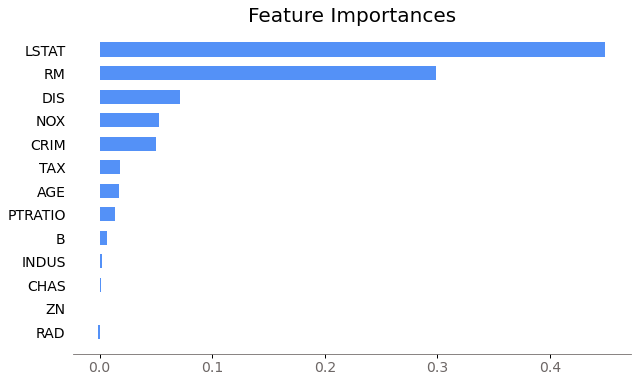

In [9]:
perm_importance = permutation_importances(rgr, X, y, metric='r2', random_state=31)
plot_feature_importances(perm_importance, feature_names)

#### 2. Compute Permutation Feature Importance with "random" feature

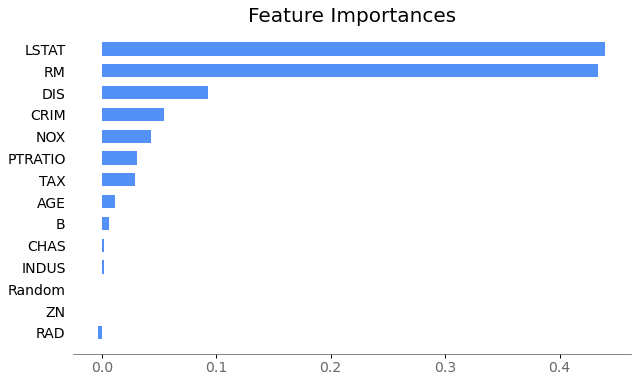

In [22]:
perm_importance_rand = permutation_importances(rgr, X_new, y, metric='r2', random_state=31)
plot_feature_importances(perm_importance_rand, np.append(rgr_data['feature_names'], ['Random'], axis=0))

**Observation**: Notice that with Permutation Importance, it gives "Random" feature close to 0 importance. This indicate that it does not affect the model's performance<br>

<br>

### 1.1.2 Drop Column Importance
The concept is also as simple and straight forward as permutation importance. The importance of a feature $x_j$ is measure by the drop in the model's performance or<br> the increase in the model's error after
complete dropping it and train the model without $x_j$. The more the model's performance drops, the more "important" a feature is.

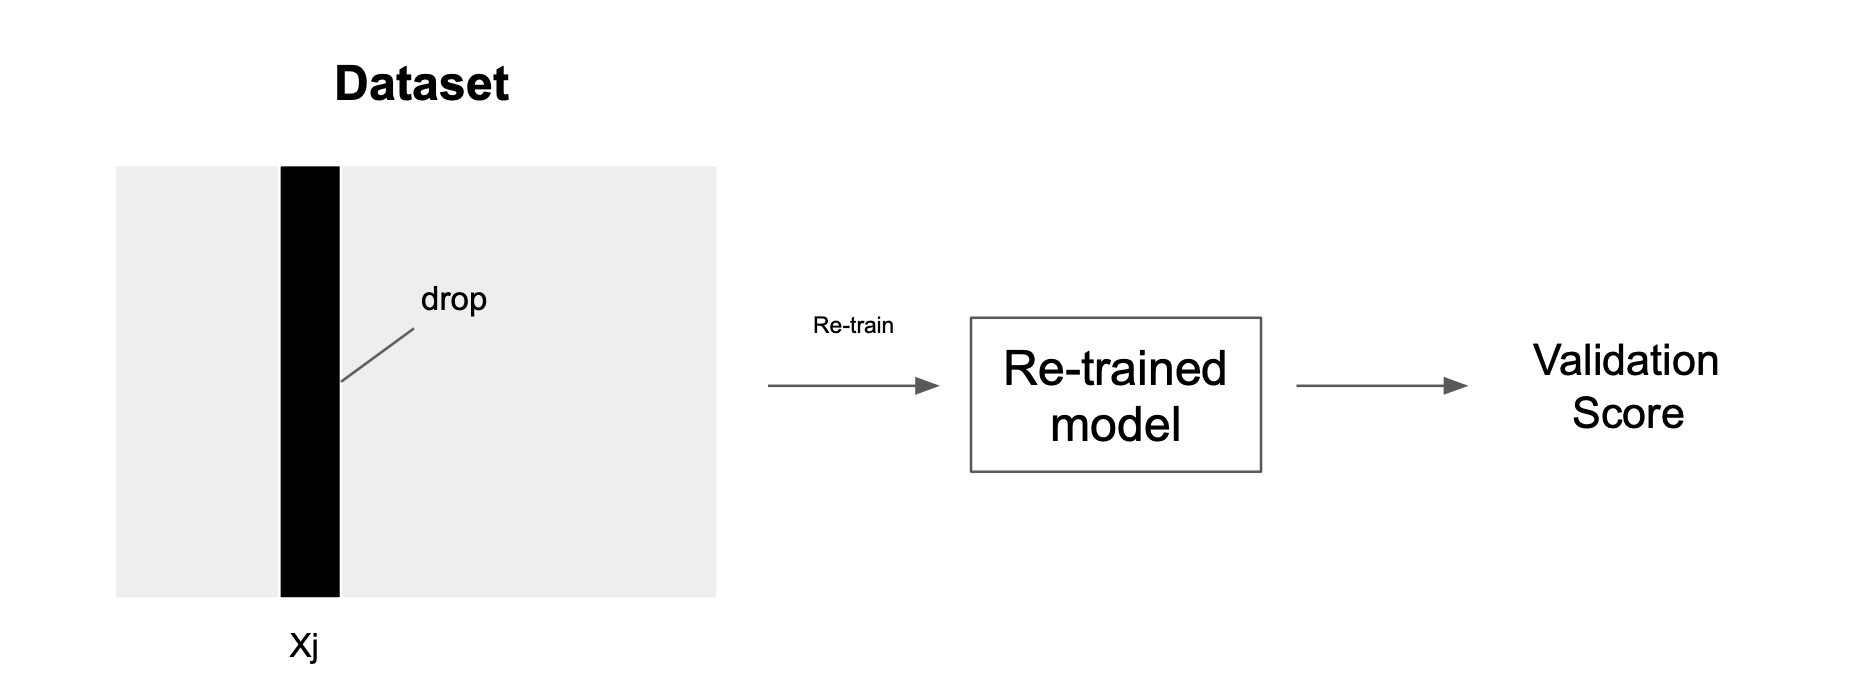

In [54]:
from IPython.display import Image
Image(filename="resources/drop.png")

### Algorithm
1. Train the model on the original data.
2. Compute the original model validation metric. Use this value as the baseline <br>(We are going to use R-sqaured for regression and Accuracy for Classification in this document, however it can by any metrics.)
3. for feature j = 1, 2, ...., p do:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Create a copy of the original data and without feature $x_j$ <br>
    &nbsp;&nbsp;&nbsp;&nbsp;Compute validation metric by training the new model from new dataset <br>
    &nbsp;&nbsp;&nbsp;&nbsp;Calculate Feature Importance score by measuring a drop in the validation metric from base line

Note: This method is more computational expensive than permutation importance as we train a new model in every iteration.

#### Example #3 Drop Column Importance
We are going to compare how "random" feature performs compare to Default sklearn's Random Forest Feature Import example.

#### 1. Compute Original Drop Column Feature Importance

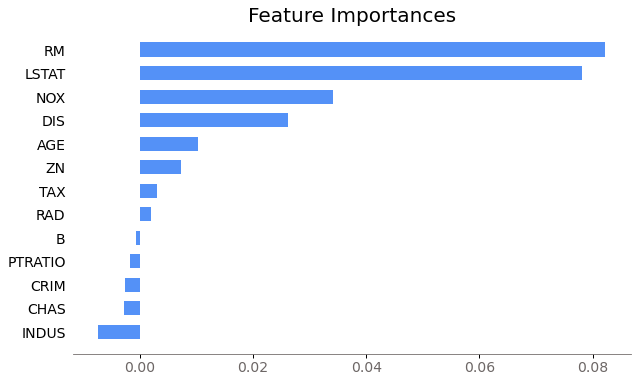

In [23]:
drop_importance = dropcol_importances(rgr, X, y, metric='r2', random_state=42)
plot_feature_importances(drop_importance, rgr_data['feature_names'])

#### 2. Compute Drop Column Feature Importance with "random" feature

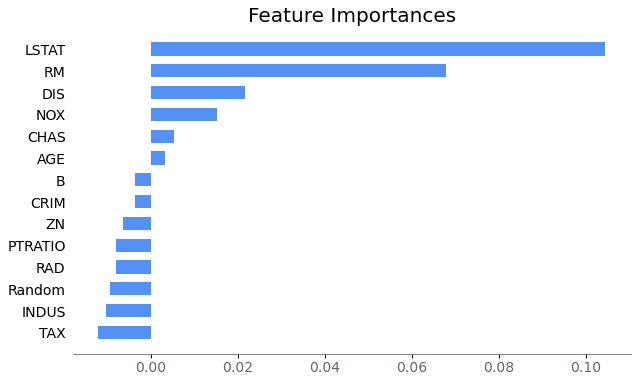

In [24]:
drop_importance_rand = dropcol_importances(rgr, X_new, y, metric='r2', random_state=42)
plot_feature_importances(drop_importance_rand, np.append(rgr_data['feature_names'], ['Random'], axis=0))

**Observation**: Notice that with Drop Column Importance, it gives "Random" feature *minus* importance. This indicate that dropping it improves our validation metric<br>

<br>

### **Caution:** Both Permutation importance and Drop column importance assess *importance* of each feature individually. Thus, they are **prone to misinterpreting codependent features**. 
- Drop column importance tends to **give zero importance to redundant features**, while 
- Permutation importance tends to **share importance among redundant features.**

<br>

## 2. Calculate Feature Importance by working directly from the data (model-free)
## 2.1 Spearman's rank correlation coefficient 
Spearman's rank correlation coefficient is almost the same as the simple Pearson's correlation cofficient. Instead of directly evaluate linear relationship between 2 variables, Spearman's rank evaluate linear relationship between 2 **rank** value of variables.
The advantage of Spearman's rank correlation over Pearson's correlation is that It can assesses monotonic relationships whether it's linear or not !


#### Example #4 (absolute) Spearman's rank Importance

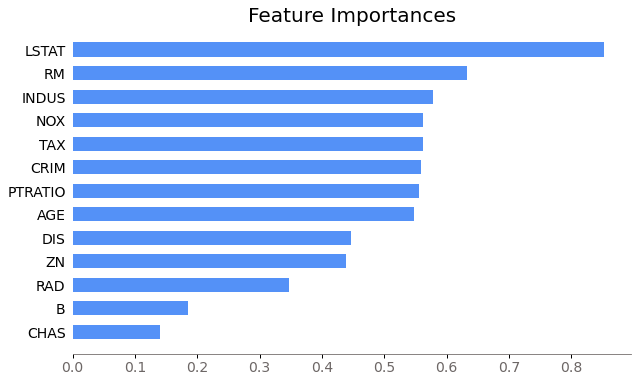

In [25]:
spearmanr_imp = spearmanr_importance(X, y)
plot_feature_importances(spearmanr_imp, feature_names)

## 2.2 mRMR (minimum Redundancy Maximum Relevance)
First, let's take a look at Relevant and Redundant features definition in feature selection. <br>
**- Relevance Features:** Features that individually have significant contribute to predicting response variable y  <br>
**- Redundant Features:** If feature1 and feature2 are both relavant, but the share the same information. They're considered as **redundant** <br>
<br>Most of the feature importance focus on only Maximizing Relevance of features, whereas **mRMR originally design for both<br> Maximixing Relavance and Minimizing Redundancy** In short, mRMR can deal with the effect of co-dependence features  !

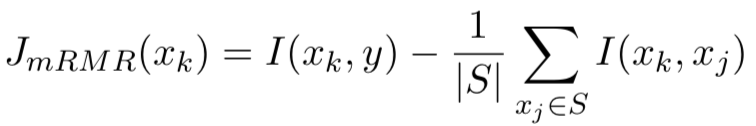

In [55]:
from IPython.display import Image
Image(filename="resources/MRMR.png")

### Algorithm
I(xk, y) function in mRMR can be mutual information, pearson correlation coefficient, or Spearman's rank coefficient.
In this document, we implement Spearman's rank coefficient version.
1. Compute the absolute (we only care about magnitude) Spearman's rank coefficient of feature $x_k$ and response variable y
2. Compute the absolute Spearman's rank coefficient of feature $x_k$ and other variable $x_j$ where j != k
3. Compute the average of Spearman's rank coefficient of feature $x_k$ and other variable $x_j$
4. mRMR score = value in step1. minus value in step3.

#### Example #5 mRMR Importance

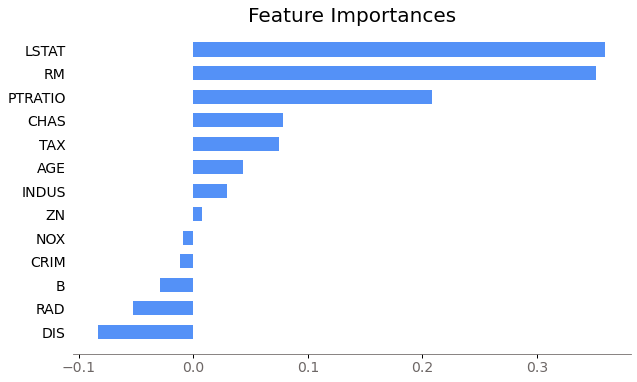

In [26]:
plot_feature_importances(mRMR(X,y), feature_names)

<br>

## Feature Importance Strategies Comparison 

We are going to compare how well recommended features ranked by various feature importance techniques by fitting a model to top k features and evaluate the valiadation metric (R-Squared) as top k features increase. We will also compare of our self-implemented methods against the famous machine learning interpretability library called SHAP  https://shap.readthedocs.io/en/latest/index.html


#### Example #6 SHAP Importance (mean absolute value)

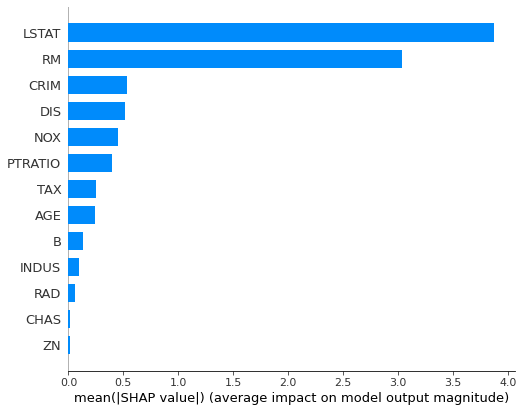

In [27]:
rgr.fit(X,y)
explainer = shap.TreeExplainer(rgr)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type = 'bar', feature_names=feature_names)
shap_importance = np.abs(shap_values).mean(0)

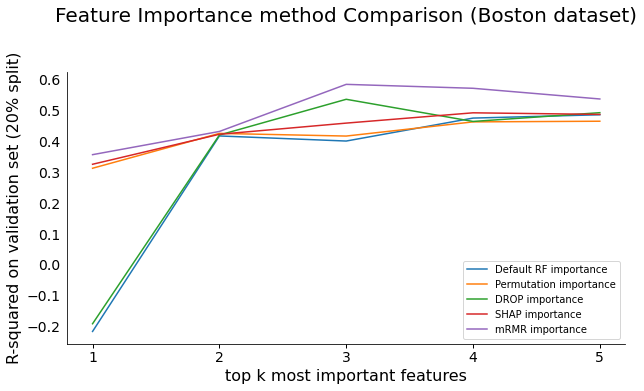

In [41]:
import matplotlib.ticker as mticker

model = RandomForestRegressor()
model.fit(X, y)
text_grey = '#6D6766'
dark_grey = '#010101'
blue = '#5491F7'
fig, ax = plt.subplots(figsize=(10,5))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis='y', labelsize=14, labelcolor=dark_grey, width=0)
ax.tick_params(axis='x', labelsize=14, labelcolor=dark_grey, width=1)
x_range = [i for i in range(1,6)]
ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
ax.plot(x_range, get_k_scores(model, X, y, 5, model.feature_importances_, feature_names), label='Default RF importance')
ax.plot(x_range, get_k_scores(model, X, y, 5, perm_importance, feature_names), label='Permutation importance')
ax.plot(x_range, get_k_scores(model, X, y, 5, drop_importance, feature_names), label='DROP importance')
ax.plot(x_range, get_k_scores(model, X, y, 5, shap_importance, feature_names), label='SHAP importance')
ax.plot(x_range, get_k_scores(model, X, y, 5, mRMR(X,y), feature_names), label='mRMR importance')
# labels
ax.set_xlabel('top k most important features', fontsize=16)
ax.set_ylabel('R-squared on validation set (20% split)', fontsize=16)
ax.set_title('Feature Importance method Comparison (Boston dataset)', fontsize=20,pad=50)
ax.legend()
plt.show()

#### Observation: **mRMR** performs really well. Its ability to maximize Relevance and Minimize Redundancy seems to be quite effective. <br>Compare with other methods, the model achieves R-squared=0.6 with only top 3 features

<br>

# Application & Adaptation

## 1. Automatic Feature Selection
Feature selection is the process of selecting the best subset of features which improves model performance, reduces risk of overfitting by reducing model complexity, and could also reduces training time. Feature Importance can be applied as a criteria for feature selection process.
In this section, we are going to use backward stepwise selection which start with the full features model, then allow one-feature-at-a-time to leave model and re-compute validation metric. If the valiadation metric drops, we stop the elimination process and return the best subset of features.


### Algorithm
1. Compute Feature Importance (Can be any methods)
2. Compute baseline validation metric from the original data (all features)
3. While (validation score after dropping least importance metric >= baseline validation metric) or
<br> (one feature left in the model) do:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - drop least importance feature measuring by provided Feature Importance <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - re-train the model with new training data <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - Compute Validation metric <br>

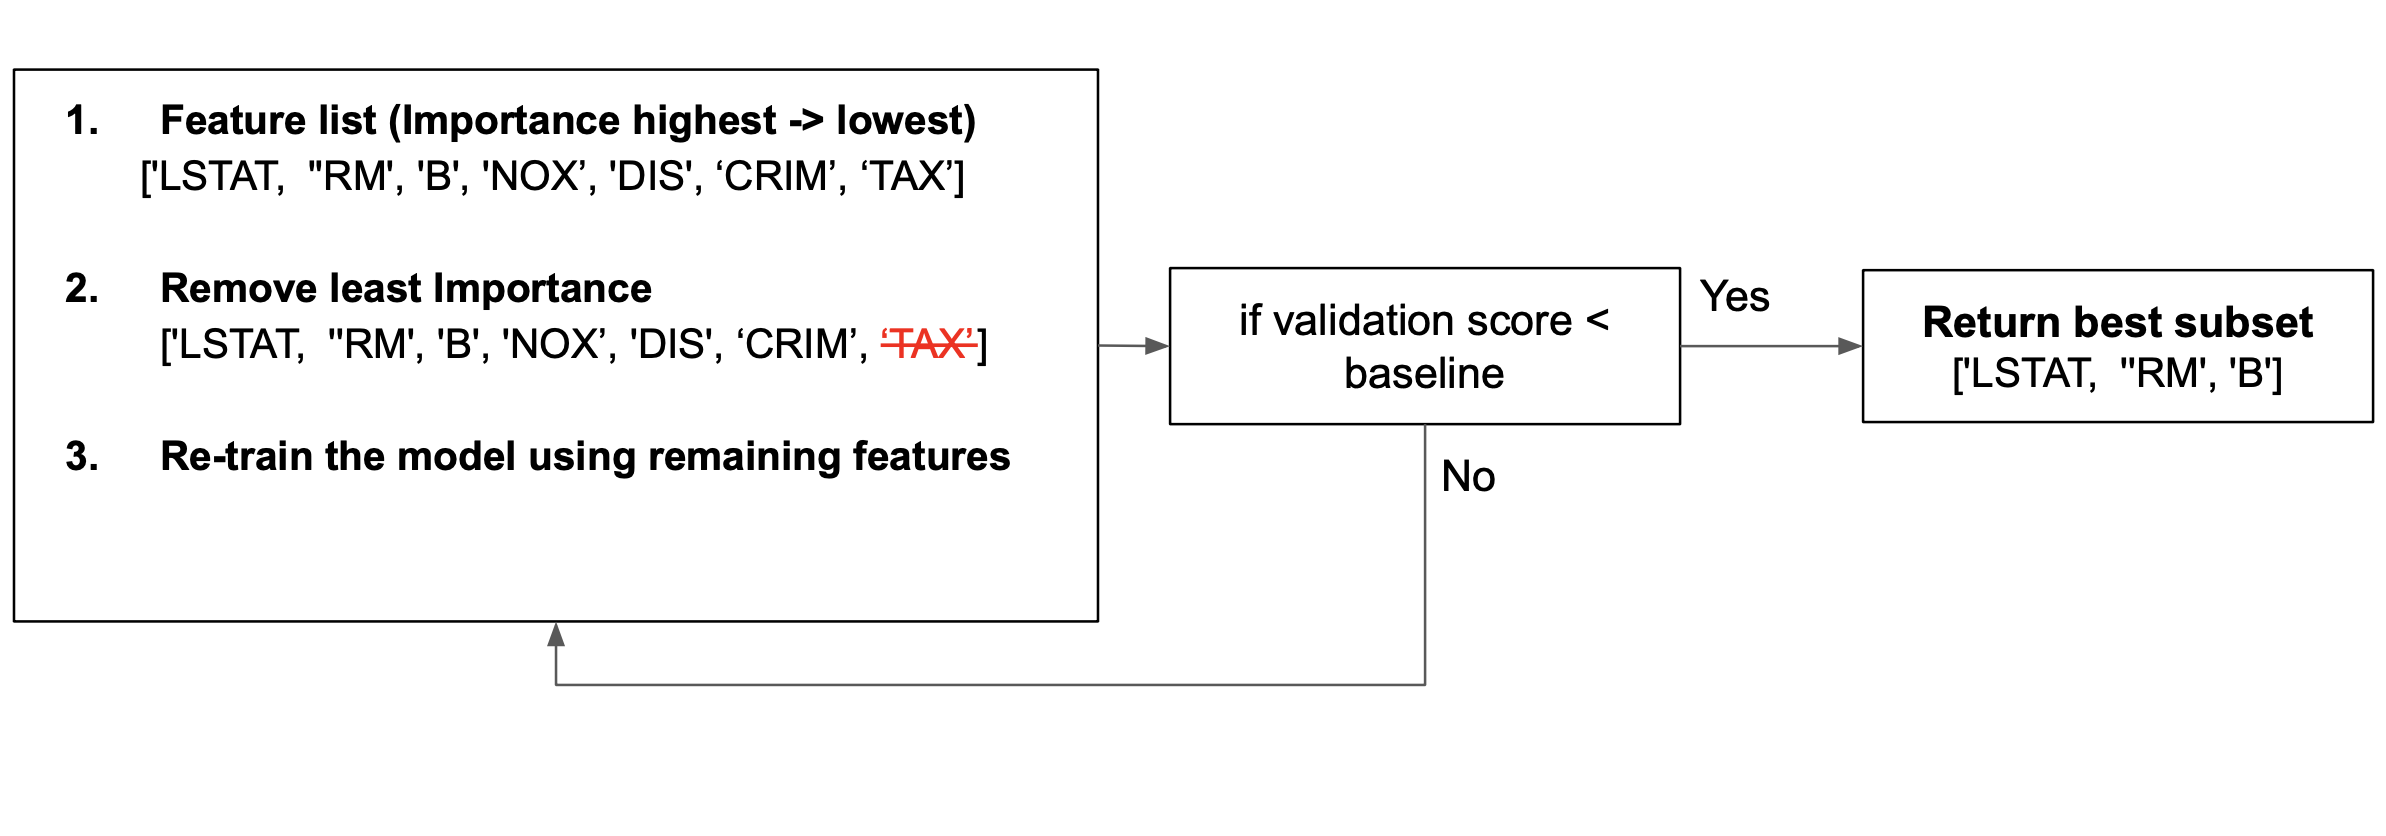

In [56]:
from IPython.display import Image
Image(filename="resources/auto.png")

#### Example #7 Automatic Feature Selection

In [42]:
best_subset = automatic_feature_selection(rgr, X, y, perm_importance, rgr_data['feature_names'], metric='r2', random_state=31)
full_features = rgr_data['feature_names']
print(f'Full features ({len(full_features)} features) ->        {sorted(list(full_features))}')
print(f'Best features subset ({len(best_subset)} features) -> {sorted(best_subset)}')

Full features (13 features) ->        ['AGE', 'B', 'CHAS', 'CRIM', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RAD', 'RM', 'TAX', 'ZN']
Best features subset (8 features) -> ['AGE', 'CRIM', 'DIS', 'LSTAT', 'NOX', 'PTRATIO', 'RM', 'TAX']


<br>

## 2. Variance and empirical p-values for feature importance
### 2.1 Variance for feature importance
We can adapt Feature Importance to provide Variance (standard deviation) using Bootstrapping (random sampling with replacement) to re-sample the original dataset. Bootstrapping allow us to perform inference about a sample from resampled data such as standard errors and confidence interval [1]


#### Example #8 Compute and plot 95% CI ($\pm$2 stdev) of Permutation Importance


In [43]:
feature_importance, std = feature_importance_std(rgr, X, y, method='permutation', metric='r2', iteration=100)
feature_names = rgr_data['feature_names']

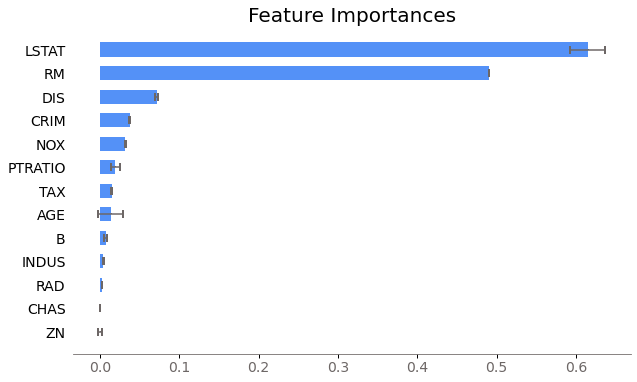

In [44]:
plot_feature_importances(feature_importance, feature_names, std)

### 2.2 Empirical p-value
We compute null distribution from feature importances fitted to noise (permuted y) and compare it to feature importances fitted to real target y.
Empirical p-value calculated from portion of times feature importance from noise is more important than real feature importance.

#### Example #9 Null distribution vs Real Importance

In [45]:
iteration = 100
null_dist = []
for i in range(iteration):
    perm_imp = permutation_importances(rgr, X, y, metric='r2', random_state=30, shuffle_y=True)
    null_dist.append(perm_imp)
null_dist = np.array(null_dist)

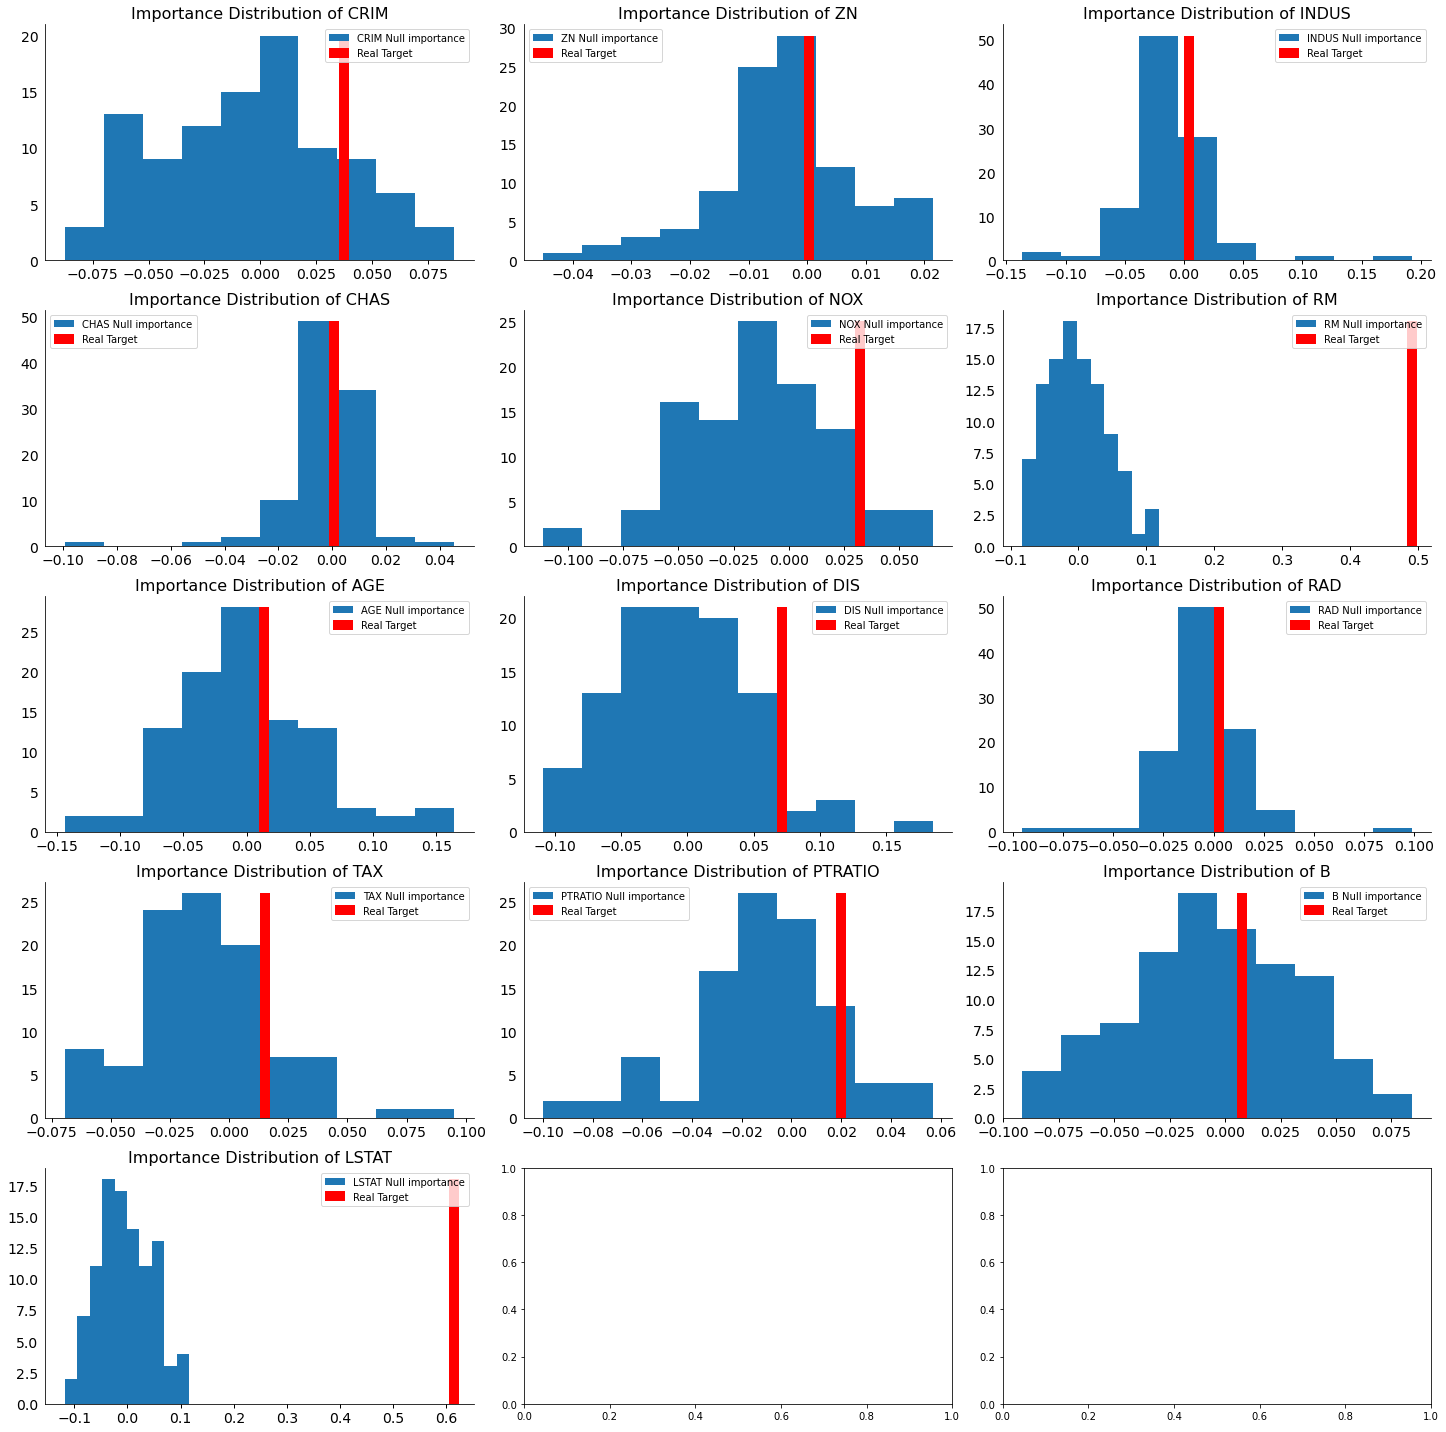

In [49]:
plot_empirical_p_value(feature_importance, null_dist, feature_names, show_all=True)

#### Example #10 Empirical p-value of a specific feature

Hypothesis Test (p_threshold=0.05)
------------------------------
empirical p-value = 0.000 < 0.05
Summary: LSTAT Importance is significant




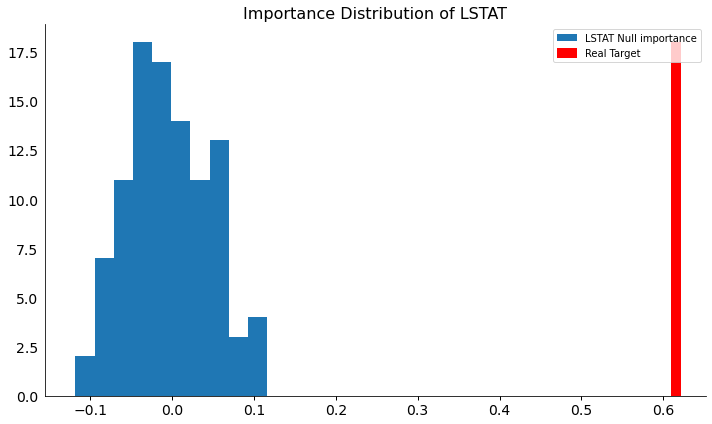

In [50]:
plot_empirical_p_value(feature_importance, null_dist, feature_names, i=12)

Hypothesis Test (p_threshold=0.05)
------------------------------
empirical p-value = 0.350 > 0.05
Summary: ZN Importance is not significant




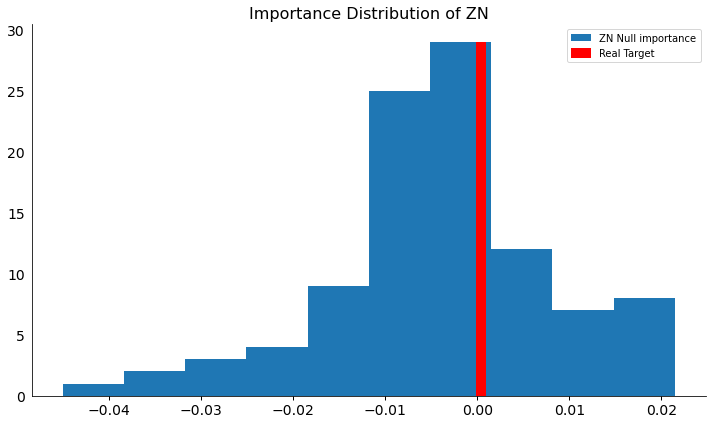

In [52]:
plot_empirical_p_value(feature_importance, null_dist, feature_names, i=1)

<br>

#### References
- https://github.com/parrt/msds689/blob/master/projects/featimp/featimp.md
- https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b
- https://link.springer.com/article/10.1186/1471-2105-8-25#Sec12
- [1] https://en.wikipedia.org/wiki/Bootstrapping_(statistics) 
- https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient